# Physics-Informed Neural Networks (PINNs) for Solving Differential Equations

This notebook demonstrates how to use PINNs to solve a 1D differential equation and create an animation showing the training progress.


## Imports and Setup

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import os
import cv2
import multiprocessing

from ML_solve__save_func import save_plot # be sure to have this file in your current working directory for concurrent image saving

image_folder = r"<path>"
animation_folder = r"<path>"
os.makedirs(image_folder, exist_ok=True)
os.makedirs(animation_folder, exist_ok=True)


## Define the PINN Model

In [3]:
class PINN1D(nn.Module):
    def __init__(self, n_neurons):
        super(PINN1D, self).__init__()
        self.input_layer = nn.Linear(1, n_neurons)
        self.hidden_layer = nn.Linear(n_neurons, n_neurons)
        self.output_layer = nn.Linear(n_neurons, 1)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.input_layer(x))
        x = self.activation(self.hidden_layer(x))
        x = self.output_layer(x)
        return x

n_neurons = 64
uNN = PINN1D(n_neurons)

## Set Up the Optimizer and Training Parameters



In [4]:
learning_rate = 0.001
weight_decay = 0.0
betas = (0.99, 0.9999)
optimizer = optim.Adam(uNN.parameters(), lr=learning_rate, weight_decay=weight_decay, betas=betas)

n_pts = 100
max_steps = 100000
x = torch.linspace(0.0, np.pi, n_pts).reshape(-1, 1)
x.requires_grad = True
x_fine = torch.linspace(0.0, np.pi, 256).reshape(-1, 1)
x_fine_np = x_fine.detach().numpy()

## Train the PINN Model

In [5]:
loss_list = []
yhat_np_list = []

step = 0
loss = 1.0

while loss > 1e-3 and step < max_steps:
    optimizer.zero_grad()
    
    yhat_save = uNN(x_fine)
    yhat_np = yhat_save.detach().numpy()
    yhat_np_list.append(yhat_np)
    
    yhat = uNN(x)
    
    dy, = torch.autograd.grad(yhat, x, torch.ones_like(yhat), create_graph=True)
    ddy, = torch.autograd.grad(dy, x, torch.ones_like(dy), create_graph=True)

    loss = ((np.pi**2 * yhat[1:] + ddy[1:])**2).mean() + (yhat[0] - 1.0)**2 + (yhat[-1] - 2.0)**2
    loss_list.append(loss.item())
    loss.backward()
    
    optimizer.step()
    step += 1
    
    if step % 1000 == 0:
        print(f'Step {step}, Loss: {loss.item()}')

loss_array = np.array(loss_list)

Step 1000, Loss: 4.458478927612305
Step 2000, Loss: 4.448883056640625
Step 3000, Loss: 4.437761306762695
Step 4000, Loss: 3.254533529281616
Step 5000, Loss: 1.0249478816986084
Step 6000, Loss: 0.04241550713777542
Step 7000, Loss: 0.005359583534300327
Step 8000, Loss: 0.0024749464355409145
Step 9000, Loss: 0.0011793897720053792


## Plot the Loss Curve

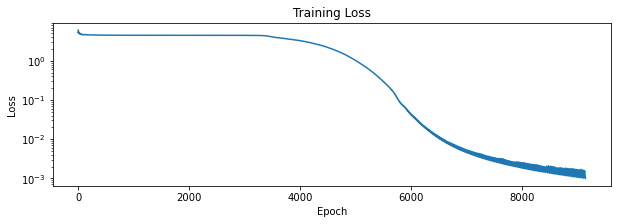

In [6]:
fig, ax = plt.subplots(figsize=(10, 3))
ax.semilogy(loss_array)
ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.set_title('Training Loss')
plt.show()

## Compare the PINN Solution with the Analytical Solution

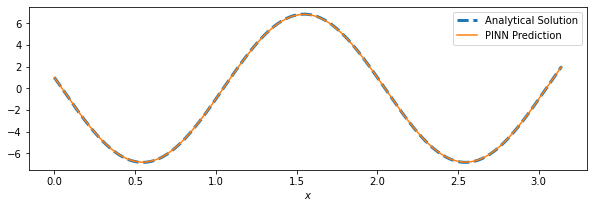

In [7]:
fig, ax = plt.subplots(figsize=(10, 3))

yhat = uNN(x_fine)
yhat_np = yhat.detach().numpy()

x_bc = torch.tensor(np.pi)
y_bc = torch.tensor(2.0)
y = torch.cos(np.pi * x_fine) + (y_bc - torch.cos(np.pi * x_bc)) * torch.sin(np.pi * x_fine) / torch.sin(np.pi * x_bc)
y_np = y.detach().numpy()

ax.plot(x_fine_np, y_np, '--', linewidth=3, label='Analytical Solution')
ax.plot(x_fine_np, yhat_np, label='PINN Prediction')
ax.set_xlabel('$x$')
ax.legend()
plt.show()

## Create Animation of the Training Process

In [8]:
def create_images(image_folder, yhat_np_list, y_np, x_fine_np, loss_array, min_value, max_value):
    save_period = 1
    args = [(i, image_folder, yhat_np_list, y_np, x_fine_np, loss_array, min_value, max_value) for i, data in enumerate(yhat_np_list) if i % save_period == 0]

    with multiprocessing.Pool() as pool:
        pool.starmap(save_plot, args)

def create_video(image_folder, video_name, fps):
    image_files = sorted([f for f in os.listdir(image_folder) if f.endswith('.png')])
    sample_image = cv2.imread(os.path.join(image_folder, image_files[0]))
    height, width, _ = sample_image.shape
    
    video_writer = cv2.VideoWriter(video_name, cv2.VideoWriter_fourcc(*'DIVX'), fps, (width, height))

    for file in image_files:
        image_path = os.path.join(image_folder, file)
        frame = cv2.imread(image_path)
        video_writer.write(frame)

    video_writer.release()

min_value = min(np.min([np.min(data) for data in yhat_np_list]), np.min(y_np))
max_value = max(np.max([np.max(data) for data in yhat_np_list]), np.max(y_np))

create_images(image_folder, yhat_np_list, y_np, x_fine_np, loss_array, min_value, max_value)

video_name = os.path.join(animation_folder, 'PINN_Solves_DE.mp4')
fps = 60
create_video(image_folder, video_name, fps)